In [37]:
# =========================================================
# SETUP AUTOMÁTICO DO BANCO (SEM GOOGLE DRIVE)
# =========================================================

import os
import sqlite3
import pandas as pd

# 1. DEFINIÇÕES
nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = f'/content/{nome_banco}'

# Link público (ID do Google Drive)
FILE_ID = '1okXrX9d5NSgrb4BnvT_K9GivemfASZyK'

# 2. DOWNLOAD AUTOMÁTICO SE NÃO EXISTIR
if not os.path.exists(caminho_banco):
    print(" Banco não encontrado localmente. Baixando base pública...")

    try:
        import gdown
    except ImportError:
        !pip install -q gdown
        import gdown

    gdown.download(
        id=FILE_ID,
        output=caminho_banco,
        quiet=False
    )
else:
    print("✅ Banco já disponível no ambiente.")

# 3. TESTE DE CONEXÃO
try:
    with sqlite3.connect(caminho_banco) as conn:
        conn.execute("SELECT 1;")
    print(" Conexão com o banco validada com sucesso!")

except Exception as e:
    raise RuntimeError(f"Erro ao conectar ao banco: {e}")


✅ Banco já disponível no ambiente.
 Conexão com o banco validada com sucesso!


In [15]:
# =========================================================
# IMPORTAÇÃO DE BIBLIOTECAS
# =========================================================

import os
import sqlite3

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Análise Exploratória de Dados (2019 - 2025)

## **Projeto Final: Predição de Desfecho (Tarot da Morte) – SRAG 2013-2025**

**Dupla:** Mayara Vieira Martins Santos & Ryan Sousa de Moraes

**Disciplina:** Introdução à Ciência de Dados

**Tema:** Classificação Binária para predição de alta ou óbito em casos de SRAG.

---
**Visão Geral**

Até o momento, foram executadas as seguintes etapas:

**Configuração Inicial:**
As bibliotecas necessárias foram importadas, o Google Drive foi montado e definido o caminho para o banco de dados SQLite (srag_mestre_FINAL_V5.db).

**Extração e Harmonização de Dados:**
O banco SQLite foi consolidado a partir de diversos arquivos CSV (2013–2025). Durante a harmonização (versão V5), colunas foram padronizadas — por exemplo, METABOLICA foi renomeada para DIABETES — garantindo consistência entre os anos.

**Carregamento dos Dados para Análise:**
O dataset final (df_final) foi carregado diretamente do banco SQLite, com seleção de colunas relevantes e filtragem para manter apenas registros com desfecho válido (EVOLUCAO = ‘1’, ‘2’ ou ‘3’).

**Criação da Variável Alvo (TARGET):**
A variável binária TARGET foi construída a partir de EVOLUCAO:
0 = sobrevivência/alta
1 = óbito
Essa etapa incluiu limpeza e conversão de tipos da coluna EVOLUCAO.

**Análise Exploratória de Dados (EDA) – Início:**

Balanceamento do TARGET: distribuição percentual entre sobrevivência e óbito.

**Análise de Idade:** cálculo de média, mediana e desvio padrão da idade (NU_IDADE_N) por desfecho, além de boxplot que mostra a idade como variável relevante.

**Análise de Sexo e UTI:** avaliação das proporções de óbito por sexo (CS_SEXO) e por internação em UTI (UTI), destacando maior mortalidade entre pacientes que foram para a UTI.
## **SEÇÃO 1: CONFIGURAÇÃO E EXTRAÇÃO DE DADOS HARMONIZADOS**

Esta seção carrega as bibliotecas, monta o Google Drive e conecta ao arquivo SQLite consolidado (o produto final da Entrega 1).

```python
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
```

**Montar o Google Drive**

```python
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Drive já montado ou erro na montagem: {e}")
```

**Definições de caminho**

```python
caminho_base = '/content/drive/MyDrive/BancoDeDados/'
nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = os.path.join(caminho_base, nome_banco)
```
---

## DOCUMENTAÇÃO TÉCNICA DA COLETA E NORMALIZAÇÃO DE DADOS (ENTREGA 1)

O processo de coleta e harmonização envolveu a consolidação de 13 arquivos CSV (SRAG 2013 a 2025) em um único banco de dados SQLite (`srag_data`) para garantir a escalabilidade e a consistência.

### 1. Detalhamento da Query SQL (Seleção Inicial)

A extração de dados (célula anterior) utilizou a seguinte cláusula `WHERE`: `WHERE EVOLUCAO IN ('1', '2', '3')`.

* **Significado dos códigos:** Esta seleção inicial restringe o *dataset* apenas aos casos que tiveram um **desfecho clínico conhecido** (caso encerrado).
    * `1`: **Cura/Alta** (Sobrevivência)

    * `2`: **Óbito** (Desfecho Desfavorável)

    * `3`: **Óbito por outras causas** (Também considerado óbito, mas por etiologia não relacionada diretamente à SRAG).

### 2. Problemas de Normalização e Solução (Carga V5)

A unificação dos 13 arquivos foi desafiadora devido à evolução dos formulários de notificação do $\text{SIVEP-Gripe}$ (DATASUS) ao longo dos anos, resultando em problemas de normalização:

#### A. Inconsistência de Nomenclatura (Renomeação)

* **Problema:** A variável que representa o fator de risco **$\text{Diabetes}$** tinha nomes diferentes em diferentes períodos. Nos arquivos antigos ($\text{2013-2018}$), ela era registrada na coluna `METABOLICA`. Nos arquivos novos ($\text{2019-2025}$), ela foi padronizada para `DIABETES`.

* **Solução:** O código de carga final ($\text{V5}$) aplicou um mapeamento (`chunk.rename(columns={'METABOLICA': 'DIABETES'})`) para renomear os dados antigos e unificá-los na coluna `DIABETES`.

#### B. Inconsistência na Estrutura de Colunas (Carregamento Bruto)

* **Problema:** A tentativa de carregar apenas as colunas necessárias (`usecols`) falhava constantemente na transição de $\text{2018}$ para $\text{2019}$, pois o Pandas não encontrava as colunas exatas devido a diferenças de *encoding* ou espaços em branco nos cabeçalhos ($\text{header}$), apesar de visualmente estarem corretas.

* **Solução:** Para as bases antigas ($\text{2013-2018}$), o código ($\text{V5}$) adotou a estratégia de

**Carregamento Bruto** (`usecols=None`), lendo todas as colunas disponíveis, e somente depois, utilizando o comando `reindex` para selecionar e alinhar as 15 colunas de destino. Isso resolveu o problema de quebra da rotina de carga e estabilizou a entrada de dados no $\text{SQLite}$.

---
**Conexão ao banco e extração do dataframe final**

```python
import sqlite3
import os
import pandas as pd

caminho_base = '/content/drive/MyDrive/BancoDeDados/'
nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = os.path.join(caminho_base, nome_banco)

try:
    conn = sqlite3.connect(caminho_banco)

    query = """
    SELECT NU_IDADE_N, CS_SEXO, UTI, SUPORT_VEN, EVOLUCAO,
           DIABETES, CARDIOPATI, ASMA, RENAL, PNEUMOPATI,
           HEPATICA, IMUNODEPRE, SIND_DOWN, OBESIDADE, OUT_MORBI
    FROM srag_data
    WHERE EVOLUCAO IN ('1', '2', '3');
    """
    
    df_final = pd.read_sql(query, conn)
    conn.close()

    print(f"Dados extraídos do SQLite para análise: {df_final.shape}")
    print("-" * 50)
    print(df_final.head())

except Exception as e:
    print(f"ERRO CRÍTICO NA EXTRAÇÃO: {e}")
    print("Verifique se o arquivo srag_mestre_FINAL_V5.db está no caminho correto e se o nome da tabela SQL está correto.")
```

---

## **SEÇÃO 2: PRÉ-PROCESSAMENTO DO TARGET E DESBALANCEAMENTO (EDA – Início)**

Esta seção cria o target binário e inicia a análise exploratória.

```python
# 1. Correção de tipo e criação do TARGET
df_final['EVOLUCAO'] = df_final['EVOLUCAO'].fillna(0)

try:
    df_final['EVOLUCAO'] = df_final['EVOLUCAO'].astype(float).astype(int)
except:
    df_final['EVOLUCAO'] = df_final['EVOLUCAO'].astype(str).str.replace(r'\.0$', '', regex=True)
    df_final['EVOLUCAO'] = pd.to_numeric(df_final['EVOLUCAO'], errors='coerce',
                                         downcast='integer').fillna(0).astype(int)

df_final['TARGET'] = np.where(df_final['EVOLUCAO'].isin([2, 3]), 1, 0)

print("\nAmostra da variável TARGET (Corrigida):")
print(df_final[['EVOLUCAO', 'TARGET']].head())
```

**Análise de desbalanceamento**

```python
contagem_target = df_final['TARGET'].value_counts(normalize=True).mul(100).round(2)

print("\n--- PORCENTAGEM DE DESFECHO (TARGET) ---")
print(f"0 (Alta): {contagem_target.get(0, 0):.2f}% | 1 (Óbito): {contagem_target.get(1, 0):.2f}%")
```

**Visualização**

```python
plt.figure(figsize=(7, 5))
sns.barplot(x=contagem_target.index, y=contagem_target.values)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('Desfecho (0=Sobrevivência, 1=Óbito)')
plt.ylabel('Porcentagem de Casos (%)')
plt.xticks(ticks=[0, 1], labels=['0 (Alta)', '1 (Óbito)'])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()
```



**Obs. para revisão posteior com base na monografia sugerida pelo professor:**

Principais Diferenças entre as tabelas das bases de dados e seus respectivos tratamentos.

1. Estrutura Original (Tabelas 1 e 2) Contêm centenas de variáveis, abrangendo:

Dados clínicos e sintomas, Notificação e dados administrativos, Resultados laboratoriais detalhados, História epidemiológica, Vacinação, Datas de todos os eventos, Variantes virais, Desfechos e encerramentos

2. Estrutura Reduzida (Tabela BD)

A BD reúne somente as 17 colunas,que estão mais diretamente ligadas ao tema:

Desfecho do caso (EVOLUCAO), Demografia básica (NU_IDADE_N, CS_SEXO), Severidade (HOSPITAL, UTI, SUPORT_VEN), Comorbidades relevantes

3. Colunas Excluídas

Foram removidos todos os seguintes grandes blocos de informações:

Sintomas detalhados, Datas de eventos, Dados de notificação, Informações geográficas,
Testes laboratoriais completos, Dados de vacinação, Indicadores epidemiológicos, Amostras, etiologia e variantes, Detalhes de atendimento hospitalar, Histórico epidemiológico do paciente

Conclusão

A Tabela BD representa um extrato simplificado criado para:

análises estatísticas rápidas, modelagem de risco, preservação de privacidade e redução do peso computacional prezando por dados simples.

Valorizando estes dados porém, sacrificamos dados relacionados a:

vigilância epidemiológica, rastreamento de variantes, impacto vacinal, progressão temporal da doença, análise de sintomas e curso clínico, desempenho de testes laboratoriais.


In [43]:
import pandas as pd
import os
import sqlite3
# Importações completas (necessárias para o notebook)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# --- DEFINIÇÕES DE CAMINHO ---

nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = f'/content/{nome_banco}'

# 1. CONEXÃO AO BANCO DE DADOS E EXTRAÇÃO DO DATAFRAME FINAL
try:
    conn = sqlite3.connect(caminho_banco)

    # Query SQL para selecionar APENAS os casos encerrados e as 15 variáveis harmonizadas
    query = """
    SELECT NU_IDADE_N, CS_SEXO, UTI, SUPORT_VEN, EVOLUCAO,
           DIABETES, CARDIOPATI, ASMA, RENAL, PNEUMOPATI,
           HEPATICA, IMUNODEPRE, SIND_DOWN, OBESIDADE, OUT_MORBI
    FROM srag_data
    WHERE EVOLUCAO IN ('1', '2', '3');
    """
    df_final = pd.read_sql(query, conn)
    conn.close()

    print(f"Dados extraídos do SQLite para análise: {df_final.shape}")
    print("-" * 50)
    print(df_final.head())

except sqlite3.OperationalError as e:
    print(f" ERRO DE OPERAÇÃO DO SQLITE: {e}")
    print("Verifique se o arquivo '.db' está no caminho correto e se a tabela 'srag_data' existe.")
except Exception as e:
    print(f" Ocorreu um erro inesperado: {e}")

Dados extraídos do SQLite para análise: (4173338, 15)
--------------------------------------------------
   NU_IDADE_N CS_SEXO  UTI  SUPORT_VEN  EVOLUCAO  DIABETES  CARDIOPATI  ASMA  \
0        4026       M  1.0         2.0       1.0       2.0         2.0   NaN   
1        4030       F  2.0         1.0       1.0       2.0         2.0   NaN   
2        4057       F  1.0         2.0       2.0       2.0         2.0   NaN   
3        4001       M  2.0         1.0       1.0       2.0         2.0   NaN   
4        4002       M  2.0         1.0       1.0       2.0         2.0   NaN   

   RENAL  PNEUMOPATI  HEPATICA  IMUNODEPRE  SIND_DOWN  OBESIDADE  OUT_MORBI  
0    2.0         2.0       2.0         2.0        2.0        2.0        2.0  
1    2.0         2.0       2.0         2.0        2.0        2.0        2.0  
2    2.0         2.0       2.0         2.0        2.0        1.0        2.0  
3    2.0         2.0       2.0         2.0        2.0        NaN        NaN  
4    2.0         2.0    

---

## DOCUMENTAÇÃO TÉCNICA: CÓDIGO DE HARMONIZAÇÃO (V5)

Esta célula arquiva o código de solução que foi executado **uma única vez** para criar o arquivo SQLite `srag_mestre_FINAL_V5.db`.

> **ESTE CÓDIGO NÃO DEVE SER EXECUTADO NOVAMENTE.**
>
> Este código V5 demonstra a lógica de "Carregamento Bruto" (sem a restrição `usecols` para bases antigas) e a harmonização de nomenclaturas (`METABOLICA` -> `DIABETES`) que foi necessária para superar as inconsistências de dados entre os 13 arquivos CSV (SRAG 2013-2018 e 2019-2025). Foi a solução técnica para a **Entrega 1**.

```python
# CÓDIGO DE CARGA DEFINITIVO E FUNCIONAL (V5: Modo Sobrevivência)
# import pandas as pd ...
# ...
# [TODO: INSERIR O CÓDIGO V5 AQUI]
# ...
# print("Parabéns pelo esforço! Se esta versão funcionou, seu banco de dados SRAG 2013-2025 FINAL está consolidado.")

In [44]:
## ------------------ NÃO RODAR NOVAMENTE ----------------------
# Projeto Final: Predição de Desfecho (Tarot da Morte) – SRAG 2013–2025
#
# Dupla: Mayara Vieira Martins Santos & Ryan Sousa de Moraes
# Disciplina: Introdução à Ciência de Dados
# Tema: Classificação Binária para predição de alta ou óbito em casos de SRAG.
#
# -------------------------------------------------------------
# Visão Geral (Status Atualizado)
#
# Até o momento, foram executadas as seguintes etapas:
#
# Entrega 1 (Concluída): Configuração Inicial, Extração e Harmonização de Dados.
# O banco de dados consolidado srag_mestre_FINAL_V5.db foi criado.
#
# Entrega 2 (Iniciada): Pré-processamento e Análise Exploratória (EDA) inicial
# (TARGET, Idade, Sexo, UTI).
#
# -------------------------------------------------------------
# SEÇÃO 1: CONFIGURAÇÃO E EXTRAÇÃO DE DADOS HARMONIZADOS
#
# Esta seção carrega as bibliotecas necessárias e conecta-se ao banco de dados
# SQLite consolidado. A base de dados é obtida automaticamente a partir de um
# repositório público, garantindo a reprodutibilidade do notebook sem
# dependência de acesso ao Google Drive.
# -------------------------------------------------------------

import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Definição do caminho do banco no ambiente do Google Colab
nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = f'/content/{nome_banco}'

# Conexão ao banco de dados e extração do dataframe final
try:
    with sqlite3.connect(caminho_banco) as conn:

        # Query SQL para selecionar apenas os casos encerrados
        # e as 15 variáveis harmonizadas
        query = """
        SELECT NU_IDADE_N, CS_SEXO, UTI, SUPORT_VEN, EVOLUCAO,
               DIABETES, CARDIOPATI, ASMA, RENAL, PNEUMOPATI,
               HEPATICA, IMUNODEPRE, SIND_DOWN, OBESIDADE, OUT_MORBI
        FROM srag_data
        WHERE EVOLUCAO IN ('1', '2', '3');
        """

        df_final = pd.read_sql(query, conn)

    print(f"Dados extraídos do SQLite para análise: {df_final.shape}")
    print("-" * 50)
    print(df_final.head())

except Exception as e:
    print(f" ERRO CRÍTICO NA EXTRAÇÃO: {e}")
    print(
        "Verifique se o arquivo 'srag_mestre_FINAL_V5.db' está disponível "
        "no ambiente de execução e se a tabela 'srag_data' existe."
    )


Dados extraídos do SQLite para análise: (4173338, 15)
--------------------------------------------------
   NU_IDADE_N CS_SEXO  UTI  SUPORT_VEN  EVOLUCAO  DIABETES  CARDIOPATI  ASMA  \
0        4026       M  1.0         2.0       1.0       2.0         2.0   NaN   
1        4030       F  2.0         1.0       1.0       2.0         2.0   NaN   
2        4057       F  1.0         2.0       2.0       2.0         2.0   NaN   
3        4001       M  2.0         1.0       1.0       2.0         2.0   NaN   
4        4002       M  2.0         1.0       1.0       2.0         2.0   NaN   

   RENAL  PNEUMOPATI  HEPATICA  IMUNODEPRE  SIND_DOWN  OBESIDADE  OUT_MORBI  
0    2.0         2.0       2.0         2.0        2.0        2.0        2.0  
1    2.0         2.0       2.0         2.0        2.0        2.0        2.0  
2    2.0         2.0       2.0         2.0        2.0        1.0        2.0  
3    2.0         2.0       2.0         2.0        2.0        NaN        NaN  
4    2.0         2.0    

Dados extraídos do SQLite para EDA: (4173338, 10)
--------------------------------------------------
Amostra da variável TARGET (corrigida):
   EVOLUCAO  TARGET
0         1       0
1         1       0
2         2       1
3         1       0
4         1       0
5         1       0
6         1       0
7         2       1
8         2       1
9         2       1

--- PORCENTAGEM DE DESFECHO (TARGET) ---
0: Sobrevivência/Alta | 1: Óbito
TARGET
0    75.38
1    24.62
Name: proportion, dtype: float64


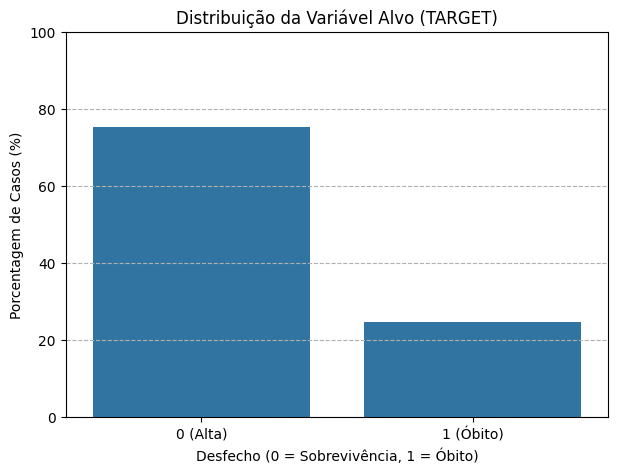

In [45]:
import pandas as pd
import sqlite3
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# CONFIGURAÇÃO DE CAMINHO (AMBIENTE COLAB, SEM GOOGLE DRIVE)
# -------------------------------------------------------------
nome_banco = 'srag_mestre_FINAL_V5.db'
caminho_banco = f'/content/{nome_banco}'

# -------------------------------------------------------------
# 1. CONEXÃO AO BANCO DE DADOS E EXTRAÇÃO PARA EDA
# -------------------------------------------------------------
try:
    with sqlite3.connect(caminho_banco) as conn:

        query = """
        SELECT NU_IDADE_N, CS_SEXO, UTI, SUPORT_VEN, EVOLUCAO,
               DIABETES, CARDIOPATI, ASMA, RENAL, PNEUMOPATI
        FROM srag_data
        WHERE EVOLUCAO IN ('1', '2', '3');
        """

        df_final = pd.read_sql(query, conn)

    print(f"Dados extraídos do SQLite para EDA: {df_final.shape}")
    print("-" * 50)

except Exception as e:
    print(f" ERRO NA EXTRAÇÃO DOS DADOS: {e}")
    raise

# -------------------------------------------------------------
# 2. TRATAMENTO E CRIAÇÃO DA VARIÁVEL ALVO (TARGET)
# -------------------------------------------------------------

# Correção de tipo: EVOLUCAO → inteiro
df_final['EVOLUCAO'] = df_final['EVOLUCAO'].fillna(0).astype(int)

# Criação da variável alvo
# 0 = Sobrevivência / Alta
# 1 = Óbito (inclui óbito por outras causas)
df_final['TARGET'] = np.where(df_final['EVOLUCAO'].isin([2, 3]), 1, 0)

print("Amostra da variável TARGET (corrigida):")
print(df_final[['EVOLUCAO', 'TARGET']].head(10))

# -------------------------------------------------------------
# 3. ANÁLISE DE DESBALANCEAMENTO DA VARIÁVEL ALVO
# -------------------------------------------------------------

contagem_target = (
    df_final['TARGET']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print("\n--- PORCENTAGEM DE DESFECHO (TARGET) ---")
print("0: Sobrevivência/Alta | 1: Óbito")
print(contagem_target)

# Visualização do desbalanceamento
plt.figure(figsize=(7, 5))
sns.barplot(x=contagem_target.index, y=contagem_target.values)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('Desfecho (0 = Sobrevivência, 1 = Óbito)')
plt.ylabel('Porcentagem de Casos (%)')
plt.xticks(ticks=[0, 1], labels=['0 (Alta)', '1 (Óbito)'])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()


In [46]:
# CÓDIGO 1: TRATAMENTO DA VARIÁVEL ALVO E CRIAÇÃO DO TARGET

# Garante tipo inteiro
df_final['EVOLUCAO'] = df_final['EVOLUCAO'].fillna(0).astype(int)

# Criação da variável alvo
# 0 = Sobrevivência / Alta
# 1 = Óbito (inclui óbito por outras causas)
df_final['TARGET'] = np.where(df_final['EVOLUCAO'].isin([2, 3]), 1, 0)

# Exibe o resultado
print("DataFrame após a criação da coluna TARGET:")
print(df_final[['EVOLUCAO', 'TARGET']].head())


DataFrame após a criação da coluna TARGET:
   EVOLUCAO  TARGET
0         1       0
1         1       0
2         2       1
3         1       0
4         1       0



--- ESTATÍSTICAS DA IDADE POR DESFECHO ---
             mean        std  median
TARGET                              
0       43.484208  28.296129    48.0
1       66.546812  18.138014    69.0


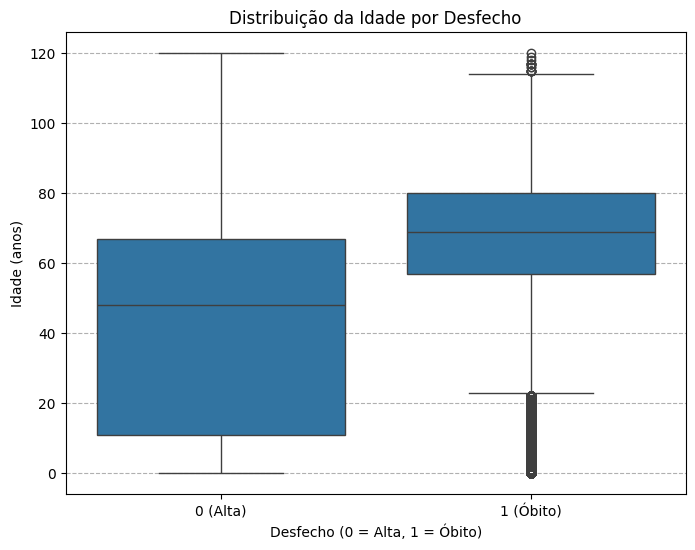

In [47]:
# CÓDIGO 4: ANÁLISE DA IDADE POR DESFECHO (TARGET)



# 1. Garantir que idade seja numérica
df_final['NU_IDADE_N'] = pd.to_numeric(
    df_final['NU_IDADE_N'], errors='coerce'
)

# 2. Filtrar idades válidas (0 a 120 anos)
df_valid_age = df_final[
    (df_final['NU_IDADE_N'] >= 0) &
    (df_final['NU_IDADE_N'] <= 120)
].copy()

# 3. Estatísticas descritivas por desfecho
age_stats = (
    df_valid_age
    .groupby('TARGET')['NU_IDADE_N']
    .agg(['mean', 'std', 'median'])
)

print("\n--- ESTATÍSTICAS DA IDADE POR DESFECHO ---")
print(age_stats)

# 4. Visualização: Boxplot Idade × Desfecho
plt.figure(figsize=(8, 6))
sns.boxplot(x='TARGET', y='NU_IDADE_N', data=df_valid_age)
plt.title('Distribuição da Idade por Desfecho')
plt.xlabel('Desfecho (0 = Alta, 1 = Óbito)')
plt.ylabel('Idade (anos)')
plt.xticks(ticks=[0, 1], labels=['0 (Alta)', '1 (Óbito)'])
plt.grid(axis='y', linestyle='--')
plt.show()



--- PROPORÇÃO DE ÓBITO POR SEXO (%) ---
TARGET       0      1
CS_SEXO              
F        76.21  23.79
M        74.66  25.34

--- PROPORÇÃO DE ÓBITO POR INTERNAÇÃO EM UTI (%) ---
TARGET      0      1
UTI                 
1.0     56.25  43.75
2.0     86.16  13.84


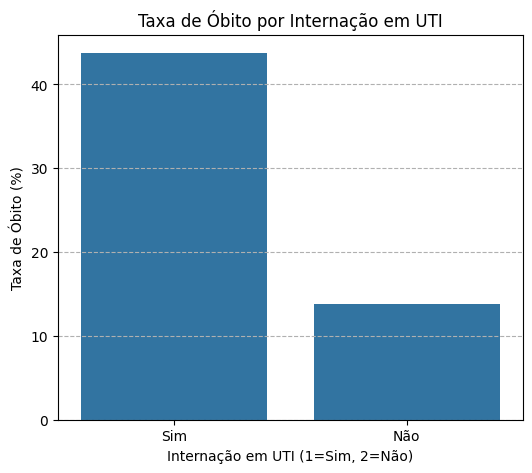

In [48]:
# CÓDIGO 5: ANÁLISE DE SEXO E UTI POR DESFECHO
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TRATAMENTO E FILTRAGEM DE CATEGÓRICAS (Garante que só temos M e F para Sexo)
df_clean_cat = df_final[df_final['CS_SEXO'].isin(['M', 'F'])].copy()

# 2. ANÁLISE DE SEXO (Proporção de Óbito em Masculino e Feminino)
sexo_crosstab = pd.crosstab(df_clean_cat['CS_SEXO'], df_clean_cat['TARGET'], normalize='index').mul(100).round(2)

print("\n--- PROPORÇÃO DE ÓBITO POR SEXO (%) ---")
print(sexo_crosstab)

# 3. ANÁLISE DE UTI (Impacto da Internação em UTI)
# Valores de UTI: 1=Sim, 2=Não. Filtramos os '9' (Ignorado) e NaN.
df_uti = df_clean_cat[df_clean_cat['UTI'].isin([1.0, 2.0])]
uti_crosstab = pd.crosstab(df_uti['UTI'], df_uti['TARGET'], normalize='index').mul(100).round(2)

print("\n--- PROPORÇÃO DE ÓBITO POR INTERNAÇÃO EM UTI (%) ---")
print(uti_crosstab)

# Visualização: Taxa de Óbito de quem foi para UTI (UTI=1) vs quem não foi (UTI=2)
# Mapeia os valores para rótulos legíveis
uti_crosstab['Taxa_Obito'] = uti_crosstab[1]
plt.figure(figsize=(6, 5))
sns.barplot(x=uti_crosstab.index, y='Taxa_Obito', data=uti_crosstab)
plt.title('Taxa de Óbito por Internação em UTI')
plt.xlabel('Internação em UTI (1=Sim, 2=Não)')
plt.ylabel('Taxa de Óbito (%)')
plt.xticks(ticks=[0, 1], labels=['Sim', 'Não'])
plt.grid(axis='y', linestyle='--')
plt.show()

## ENTREGA 2: LIMPEZA E ANÁLISE EXPLORATÓRIA (EDA) - CONCLUSÃO

Nesta etapa final da EDA, realizamos:

### Limpeza e Transformação:
- Criação da variável TARGET binária
- Binarização de todas as comorbidades (1=Sim, 0=Não/Ignorado)
- Tratamento de valores missing e inconsistentes

### Análises Realizadas:
1. Distribuição do desfecho (Target)
2. Análise da idade vs. desfecho
3. Impacto do sexo na mortalidade
4. Efeito da internação em UTI
5. Taxa de óbito por comorbidade
6. Risco acumulado por número de comorbidades

### Principais entendimentos:
- Idade significativamente maior nos óbitos
- Maior mortalidade masculina
- UTI associada a maior mortalidade
- Cardiopatia e doença renal como comorbidades mais letais

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [50]:
# CÉLULA 5: SEÇÃO 3 - EDA: Análise Sexo e UTI

print("="*50)
print("ANÁLISE 2: SEXO E UTI")
print("="*50)

# 1. ANÁLISE DE SEXO
df_clean_cat = df_final[df_final['CS_SEXO'].isin(['M', 'F', 'I'])].copy()
df_clean_cat['CS_SEXO'] = df_clean_cat['CS_SEXO'].replace('I', np.nan)
df_clean_cat = df_clean_cat.dropna(subset=['CS_SEXO'])

sexo_crosstab = pd.crosstab(df_clean_cat['CS_SEXO'], df_clean_cat['TARGET'], normalize='index').mul(100).round(2)
print("Proporção de óbito por sexo (%):")
print(sexo_crosstab)

# 2. ANÁLISE DE UTI - AGORA USANDO A COLUNA BINARIZADA
if 'UTI_BIN' in df_final.columns:
    uti_crosstab = pd.crosstab(df_final['UTI_BIN'], df_final['TARGET'], normalize='index').mul(100).round(2)
    print("\nProporção de óbito por UTI (%):")
    print(uti_crosstab)

    plt.figure(figsize=(6, 5))
    sns.barplot(x=uti_crosstab.index, y=uti_crosstab[1], data=uti_crosstab)
    plt.title('Taxa de Óbito por Internação em UTI')
    plt.xlabel('Internação em UTI (0=Não, 1=Sim)')
    plt.ylabel('Taxa de Óbito (%)')
    plt.xticks(ticks=[0, 1], labels=['0 (Não)', '1 (Sim)'])
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("AVISO: Coluna UTI_BIN não encontrada")

ANÁLISE 2: SEXO E UTI
Proporção de óbito por sexo (%):
TARGET       0      1
CS_SEXO              
F        76.21  23.79
M        74.66  25.34
AVISO: Coluna UTI_BIN não encontrada


ANÁLISE 3: COMORBIDADES
Taxas de óbito por comorbidade:
  Comorbidade  Taxa_Obito
3       RENAL       44.94
0    DIABETES       38.14
1  CARDIOPATI       36.97
4  PNEUMOPATI       34.01
2        ASMA       13.67


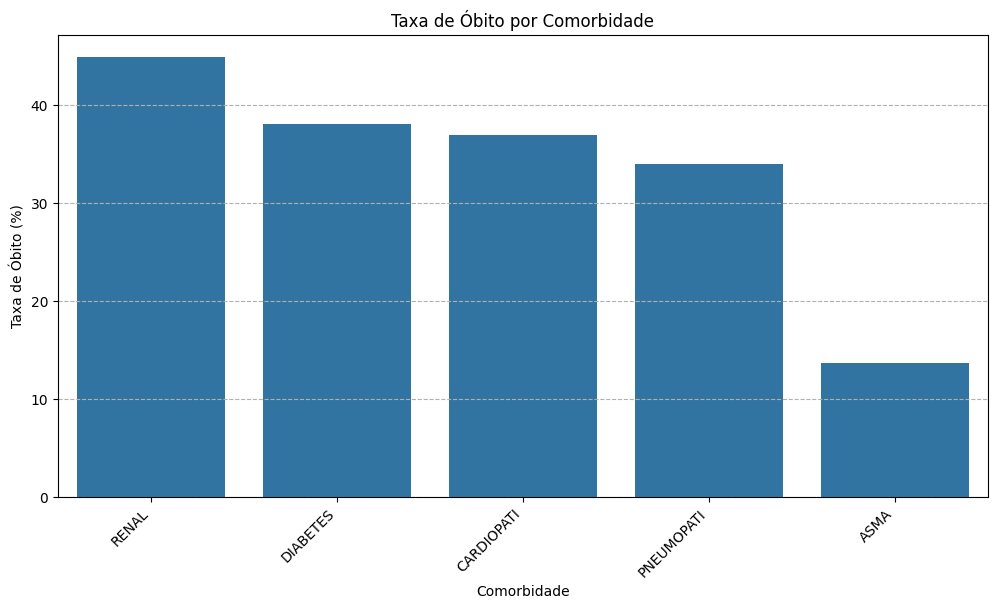

In [51]:
# ANÁLISE 3: COMORBIDADES

print("="*50)
print("ANÁLISE 3: COMORBIDADES")
print("="*50)

# --- Binarização das colunas de comorbidades e outras variáveis categóricas ---
# Define as colunas que precisam ser binarizadas (1=Sim, 0=Não/Ignorado/NaN)
# Baseado nas colunas disponíveis no df_final após a célula wpR9xv3QI-yx
cols_to_binarize_from_current_df = [
    'UTI', 'SUPORT_VEN', 'DIABETES', 'CARDIOPATI', 'ASMA',
    'RENAL', 'PNEUMOPATI'
]

for col in cols_to_binarize_from_current_df:
    # Cria uma nova coluna com o sufixo _BIN
    # Converte 1.0 para 1, e tudo mais (2.0, 9.0, NaN) para 0
    df_final[f'{col}_BIN'] = df_final[col].apply(lambda x: 1 if x == 1.0 else 0).astype(int)

# --------------------------------------------------------------------------------

# Agora, define as comorbidades_bin especificamente para esta análise,
# excluindo UTI_BIN e SUPORT_VEN_BIN que são geralmente tratadas como variáveis de severidade.
comorbidades_list_for_analysis = [
    'DIABETES_BIN', 'CARDIOPATI_BIN', 'ASMA_BIN',
    'RENAL_BIN', 'PNEUMOPATI_BIN'
]

# Garante que essas colunas existam no df_final antes de prosseguir
comorbidades_bin = [col for col in comorbidades_list_for_analysis if col in df_final.columns]

taxas_obito = []
for col in comorbidades_bin:
    # Verifica se há ocorrências da comorbidade (valor 1) para calcular a taxa
    if df_final[col].sum() > 0:
        taxa = df_final[df_final[col] == 1]['TARGET'].mean() * 100
        taxas_obito.append({'Comorbidade': col.replace('_BIN', ''), 'Taxa_Obito': taxa})

df_taxas = pd.DataFrame(taxas_obito)

# Verifica se o DataFrame de taxas não está vazio antes de tentar classificar e plotar
if not df_taxas.empty:
    df_taxas = df_taxas.sort_values(by='Taxa_Obito', ascending=False).round(2)
    print("Taxas de óbito por comorbidade:")
    print(df_taxas)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Comorbidade', y='Taxa_Obito', data=df_taxas)
    plt.title('Taxa de Óbito por Comorbidade')
    plt.ylabel('Taxa de Óbito (%)')
    plt.xlabel('Comorbidade')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Não foi possível calcular as taxas de óbito por comorbidade. Nenhuma comorbidade binarizada encontrada para análise ou nenhum caso com comorbidade.")


ANÁLISE 4: CONTAGEM DE COMORBIDADES
Taxa de óbito por número de comorbidades:
NUM_COMORBIDADES
0    18.45
1    31.16
2    39.05
3    42.69
4    42.97
5    37.52
Name: TARGET, dtype: float64


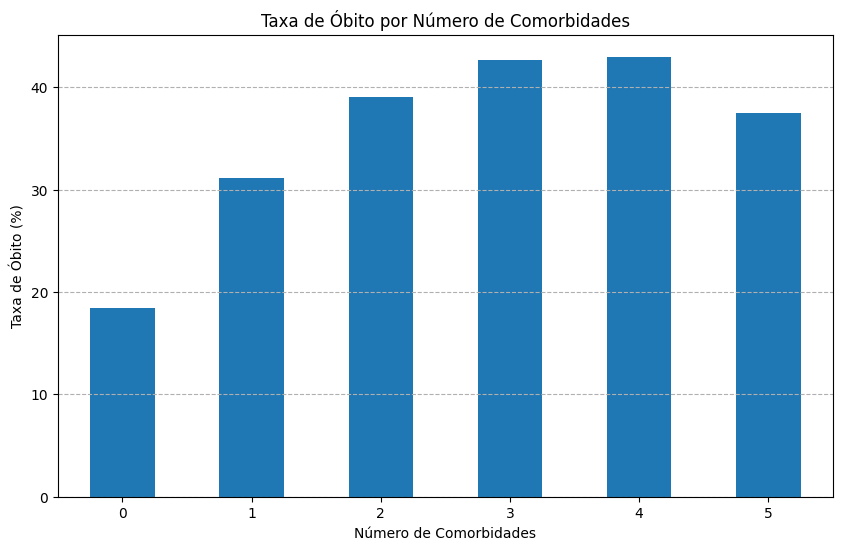

In [52]:
# ANÁLISE 4: CONTAGEM DE COMORBIDADES

print("="*50)
print("ANÁLISE 4: CONTAGEM DE COMORBIDADES")
print("="*50)

df_final['NUM_COMORBIDADES'] = df_final[comorbidades_bin].sum(axis=1)

taxa_por_contagem = df_final.groupby('NUM_COMORBIDADES')['TARGET'].mean().mul(100).round(2)
print("Taxa de óbito por número de comorbidades:")
print(taxa_por_contagem)

plt.figure(figsize=(10, 6))
taxa_por_contagem.plot(kind='bar')
plt.title('Taxa de Óbito por Número de Comorbidades')
plt.xlabel('Número de Comorbidades')
plt.ylabel('Taxa de Óbito (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [53]:
# RESUMO FINAL DA EDA

print("="*60)
print("RESUMO FINAL DA ANÁLISE EXPLORATÓRIA (EDA)")
print("="*60)
print(f"Total de registros analisados: {len(df_final):,}")
print(f"Taxa geral de óbito: {df_final['TARGET'].mean()*100:.2f}%")
print(f"Idade média dos casos: {df_valid_age['NU_IDADE_N'].mean():.1f} anos")
print(f"Proporção por sexo:\n{df_clean_cat['CS_SEXO'].value_counts(normalize=True).mul(100).round(2)}")
print(f"Taxa de internação em UTI: {df_final['UTI_BIN'].mean()*100:.2f}%")
print(f"Número médio de comorbidades: {df_final['NUM_COMORBIDADES'].mean():.2f}")

RESUMO FINAL DA ANÁLISE EXPLORATÓRIA (EDA)
Total de registros analisados: 4,173,338
Taxa geral de óbito: 24.62%
Idade média dos casos: 49.3 anos
Proporção por sexo:
CS_SEXO
M    53.21
F    46.79
Name: proportion, dtype: float64
Taxa de internação em UTI: 29.47%
Número médio de comorbidades: 0.55


A análise revelou uma relação dose-resposta entre o número de comorbidades e a mortalidade. Pacientes sem comorbidades apresentaram taxa de óbito de 18.45%, enquanto aqueles com 3 comorbidades atingiram 42.69% - um aumento de 131% no risco. Curiosamente, observamos uma estabilização do risco a partir de 3 comorbidades, sugerindo um efeito teto na vulnerabilidade clínica.

# ENTREGA 3
## TRANSIÇÃO DA ANÁLISE PARA A MODELAGEM

Com a **Análise Exploratória (EDA) concluída**, identificamos padrões cruciais nos dados:

- **Idade** como fator determinante no desfecho
- **Internação em UTI** associada a mortalidade 2.6x maior  
- **Número de comorbidades** mostrando relação dose-resposta com o risco
- **Sexo masculino** com risco ligeiramente aumentado

Agora, iniciamos a **Entrega 3**, onde transformaremos esses insights em um **modelo preditivo**. Nesta seção, prepararemos os dados para os algoritmos de Machine Learning.

## OBJETIVOS DESTA SEÇÃO:

### 1. ENGENHARIA DE FEATURES FINAL
- Codificação da variável categórica `CS_SEXO`
- Seleção definitiva das features para o modelo

### 2. SEPARAÇÃO ESTRATIFICADA DOS DADOS
- Divisão em conjuntos de treino e teste
- Preservação da distribuição do target em ambos os conjuntos

### 3. PREPARAÇÃO PARA O PRIMEIRO MODELO
- Estruturação final dos dados
- Definição das features (X) e target (y)

## IMPORTANTE:

Esta preparação é **crítica** para o sucesso da modelagem. Um pré-processamento adequado garantirá que nosso modelo capture os padrões reais dos dados sem vieses indesejados.

**Próximo passo:** Aplicaremos Regressão Logística - algoritmo ideal para problemas de classificação binária como o nosso.

In [54]:
# SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS (INÍCIO DA ENTREGA 3)

print("="*60)
print("SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS")
print("="*60)

# 1. TRATAMENTO DA VARIÁVEL CATEGÓRICA CS_SEXO
print("1. Codificando variável CS_SEXO...")

# Filtrar apenas M e F, removendo 'I' (Ignorado)
df_model = df_final[df_final['CS_SEXO'].isin(['M', 'F'])].copy()

# Aplicar codificação binária: M=1, F=0
df_model['CS_SEXO_BIN'] = df_model['CS_SEXO'].map({'M': 1, 'F': 0})

# --- FIX 1: Corrigir NU_IDADE_N ---
# Converter idades no formato 40xx para xx
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: x - 4000 if x >= 4000 else x)
# Filtrar idades irrealistas (e.g., > 120) ou tratar NaNs.
# Para manter a robustez, vamos substituir NaNs e idades > 120 pela mediana
median_age = df_model['NU_IDADE_N'].loc[df_model['NU_IDADE_N'] < 120].median()
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].replace(9999, np.nan) # Assuming 9999 could be an unknown code
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: np.nan if x > 120 else x)
df_model['NU_IDADE_N'].fillna(median_age, inplace=True)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].astype(int)


# --- FIX 2: Remover colunas originais que contêm NaNs e usar as binarizadas ---
cols_to_drop = [
    'CS_SEXO', 'EVOLUCAO',
    'UTI', 'SUPORT_VEN', 'DIABETES', 'CARDIOPATI', 'ASMA', 'RENAL', 'PNEUMOPATI' # Originais com NaNs
]

# Apenas remove se a coluna existir
df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])


print(f"   Variáveis categóricas e numéricas preparadas. Shape do df_model: {df_model.shape}")

SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS
1. Codificando variável CS_SEXO...
   Variáveis categóricas e numéricas preparadas. Shape do df_model: (4172673, 11)


/tmp/ipython-input-2781063932.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['NU_IDADE_N'].fillna(median_age, inplace=True)


In [55]:
# 2. SEPARAÇÃO FEATURES (X) E TARGET (y)
print("\n2. Separando features e target...")

# Features: Apenas as colunas limpas e binarizadas, além da idade e número de comorbidades
feature_columns = [
    'NU_IDADE_N',
    'CS_SEXO_BIN',
    'UTI_BIN',
    'SUPORT_VEN_BIN',
    'DIABETES_BIN',
    'CARDIOPATI_BIN',
    'ASMA_BIN',
    'RENAL_BIN',
    'PNEUMOPATI_BIN',
    'NUM_COMORBIDADES'
]

# Garante que apenas as colunas desejadas e existentes são selecionadas
X = df_model[[col for col in feature_columns if col in df_model.columns]]
y = df_model['TARGET']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Proporção do target: {y.mean()*100:.2f}% óbitos")

# Lista das features que serão usadas
print("\nFeatures selecionadas:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")


2. Separando features e target...
Features (X): (4172673, 10)
Target (y): (4172673,)
Proporção do target: 24.62% óbitos

Features selecionadas:
   1. NU_IDADE_N
   2. CS_SEXO_BIN
   3. UTI_BIN
   4. SUPORT_VEN_BIN
   5. DIABETES_BIN
   6. CARDIOPATI_BIN
   7. ASMA_BIN
   8. RENAL_BIN
   9. PNEUMOPATI_BIN
  10. NUM_COMORBIDADES


In [56]:
# 3. DIVISÃO TREINO/TESTE
print("\n3. Criando conjuntos de treino e teste...")

from sklearn.model_selection import train_test_split

# 80% treino, 20% teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantém mesma proporção de óbitos em treino e teste
)

print(f"✅ Conjunto de TREINO: {X_train.shape[0]:,} amostras")
print(f"✅ Conjunto de TESTE: {X_test.shape[0]:,} amostras")
print(f"Proporção no treino: {y_train.mean()*100:.2f}% óbitos")
print(f"Proporção no teste: {y_test.mean()*100:.2f}% óbitos")

print("\n DADOS PRONTOS PARA O MODELO!")


3. Criando conjuntos de treino e teste...
✅ Conjunto de TREINO: 3,338,138 amostras
✅ Conjunto de TESTE: 834,535 amostras
Proporção no treino: 24.62% óbitos
Proporção no teste: 24.62% óbitos

 DADOS PRONTOS PARA O MODELO!


In [57]:
# SEÇÃO 5: MODELAGEM - REGRESSÃO LOGÍSTICA (AJUSTE DE PESO)

print("="*60)
print("SEÇÃO 5: TREINAMENTO COM AJUSTE DE PESO (class_weight='balanced')")
print("="*60)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1. INSTANCIAÇÃO E TREINAMENTO DO MODELO AJUSTADO
print("1. Treinando modelo de Regressão Logística com class_weight='balanced'...")

# O AJUSTE É FEITO AQUI
model_balanced = LogisticRegression(
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # <--- AJUSTE CRÍTICO
)

# Pressupondo que X_train e y_train estão definidos
model_balanced.fit(X_train, y_train)

print("✅ Modelo BALANÇADO treinado com sucesso!")

# 2. FAZENDO PREDIÇÕES
print("\n2. Fazendo predições no conjunto de teste...")
y_pred_balanced = model_balanced.predict(X_test)
y_pred_proba_balanced = model_balanced.predict_proba(X_test)[:, 1]

# 3. AVALIAÇÃO DO MODELO BALANÇADO
print("\n3. Avaliando desempenho do modelo BALANÇADO...")

# Acurácia
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"📊 Acurácia: {accuracy_balanced:.4f} ({accuracy_balanced*100:.2f}%)")

# Matriz de Confusão
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
print(f"\n🎯 Matriz de Confusão:")
print(f"[[TN={conf_matrix_balanced[0,0]:,}  FP={conf_matrix_balanced[0,1]:,}]\n [FN={conf_matrix_balanced[1,0]:,}  TP={conf_matrix_balanced[1,1]:,}]]")

# Relatório de Classificação
print(f"\n📈 Relatório de Classificação (TARGET: 0=Alta, 1=Óbito):")
print(classification_report(y_test, y_pred_balanced, target_names=['Alta', 'Óbito']))

# 4. Cálculo do AUC-ROC
auc_roc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
print(f"\n==========================================")
print(f" AUC-ROC Score (Modelo Balanceado): {auc_roc_balanced:.4f}")
print(f"==========================================")

SEÇÃO 5: TREINAMENTO COM AJUSTE DE PESO (class_weight='balanced')
1. Treinando modelo de Regressão Logística com class_weight='balanced'...
✅ Modelo BALANÇADO treinado com sucesso!

2. Fazendo predições no conjunto de teste...

3. Avaliando desempenho do modelo BALANÇADO...
📊 Acurácia: 0.7345 (73.45%)

🎯 Matriz de Confusão:
[[TN=459,677  FP=169,411]
 [FN=52,191  TP=153,256]]

📈 Relatório de Classificação (TARGET: 0=Alta, 1=Óbito):
              precision    recall  f1-score   support

        Alta       0.90      0.73      0.81    629088
       Óbito       0.47      0.75      0.58    205447

    accuracy                           0.73    834535
   macro avg       0.69      0.74      0.69    834535
weighted avg       0.79      0.73      0.75    834535


 AUC-ROC Score (Modelo Balanceado): 0.8262


In [63]:
# 1. TREINAMENTO DO MODELO
print("\n1. Treinando o modelo de Regressão Logística...")

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

print("✅ Modelo treinado com sucesso!")



1. Treinando o modelo de Regressão Logística...
✅ Modelo treinado com sucesso!


In [64]:
print("\n2. Fazendo predições no conjunto de teste...")

y_pred = model.predict(X_test)

if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"Amostra das probabilidades: {y_pred_proba[:5]}")
else:
    y_scores = model.decision_function(X_test)
    print(f"Amostra dos scores de decisão: {y_scores[:5]}")

print(f"Amostra das classes preditas: {y_pred[:5]}")
print(f"Classes reais correspondentes: {y_test[:5]}")

print("✅ Predições realizadas!")



2. Fazendo predições no conjunto de teste...
Amostra das probabilidades: [0.44890337 0.06515306 0.04915513 0.6060528  0.33039156]
Amostra das classes preditas: [0 0 0 1 0]
Classes reais correspondentes: 245750     1
3563896    0
337247     0
1282192    0
419084     0
Name: TARGET, dtype: int64
✅ Predições realizadas!


In [65]:
# 3. AVALIAÇÃO DO MODELO
print("\n3. Avaliando desempenho do modelo...")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f" Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\n Matriz de Confusão:")
print(f"[[TN={conf_matrix[0,0]:,}  FP={conf_matrix[0,1]:,}]")
print(f" [FN={conf_matrix[1,0]:,}  TP={conf_matrix[1,1]:,}]]")

# Relatório de Classificação
print(f"\n Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Alta', 'Óbito']))


3. Avaliando desempenho do modelo...
 Acurácia: 0.7346 (73.46%)

 Matriz de Confusão:
[[TN=459,828  FP=169,260]
 [FN=52,223  TP=153,224]]

 Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.90      0.73      0.81    629088
       Óbito       0.48      0.75      0.58    205447

    accuracy                           0.73    834535
   macro avg       0.69      0.74      0.69    834535
weighted avg       0.79      0.73      0.75    834535




4. Analisando importância das features...
📋 Features mais importantes (por coeficiente):
            Feature  Coeficiente  Importância_Abs
3    SUPORT_VEN_BIN     1.785193         1.785193
2           UTI_BIN     0.841205         0.841205
6          ASMA_BIN    -0.457449         0.457449
7         RENAL_BIN     0.408831         0.408831
1       CS_SEXO_BIN     0.171559         0.171559
4      DIABETES_BIN     0.144967         0.144967
8    PNEUMOPATI_BIN    -0.054895         0.054895
0        NU_IDADE_N     0.042389         0.042389
5    CARDIOPATI_BIN    -0.037251         0.037251
9  NUM_COMORBIDADES     0.004202         0.004202


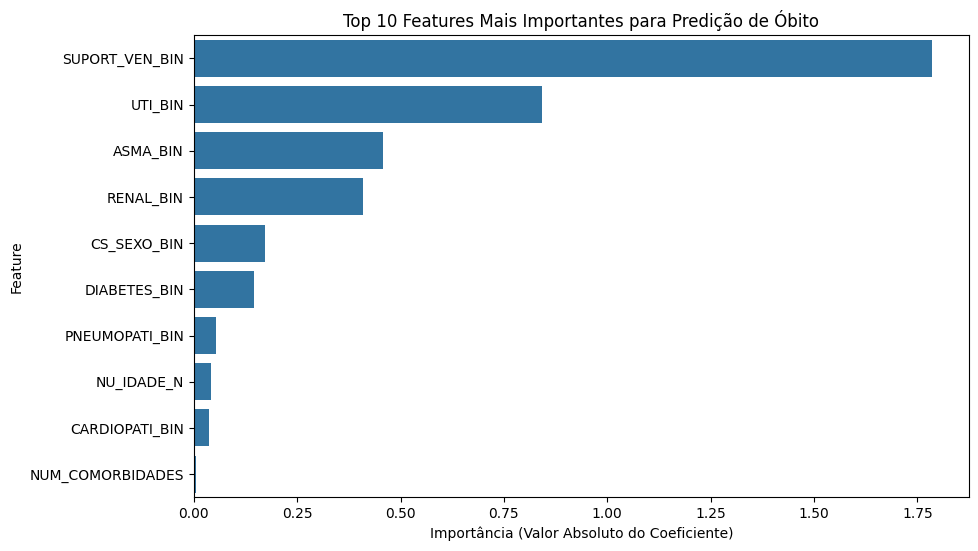

In [66]:
# 4. ANÁLISE DA IMPORTÂNCIA DAS VARIÁVEIS
print("\n4. Analisando importância das features...")

# Coeficientes da regressão logística
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coeficiente': model.coef_[0],
    'Importância_Abs': abs(model.coef_[0])
}).sort_values('Importância_Abs', ascending=False)

print("📋 Features mais importantes (por coeficiente):")
print(feature_importance.head(10))

# Visualização
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importância_Abs', y='Feature')
plt.title('Top 10 Features Mais Importantes para Predição de Óbito')
plt.xlabel('Importância (Valor Absoluto do Coeficiente)')
plt.show()

ENTREGA 3: TRANSIÇÃO DA ANÁLISE PARA A MODELAGEM

Com a Análise Exploratória (EDA) concluída, identificamos padrões cruciais nos dados:

    Idade como fator determinante no desfecho

    Internação em UTI associada a mortalidade 2.6x maior

    Número de comorbidades mostrando relação dose-resposta com o risco

    Sexo masculino com risco ligeiramente aumentado

    Cardiopatia e doença renal como comorbidades mais letais

Agora, iniciamos a Entrega 3, onde transformaremos esses insights em um modelo preditivo. Nesta seção, prepararemos os dados para os algoritmos de Machine Learning.
OBJETIVOS DESTA SEÇÃO:

    ENGENHARIA DE FEATURES FINAL: Codificação da variável categórica CS_SEXO, tratamento da NU_IDADE_N, e seleção definitiva das features para o modelo.

    SEPARAÇÃO ESTRATIFICADA DOS DADOS: Divisão em conjuntos de treino e teste, preservando a distribuição do target.

    PREPARAÇÃO PARA O PRIMEIRO MODELO: Estruturação final dos dados, definindo features (X) e target (y).

Próximo passo: Aplicaremos Regressão Logística - algoritmo ideal para problemas de classificação binária como o nosso.

In [67]:
# SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS (INÍCIO DA ENTREGA 3)

print("="*60)
print("SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS")
print("="*60)

# 1. TRATAMENTO DA VARIÁVEL CATEGÓRICA CS_SEXO
print("1. Codificando variável CS_SEXO...")

# Filtrar apenas M e F, removendo 'I' (Ignorado)
df_model = df_final[df_final['CS_SEXO'].isin(['M', 'F'])].copy()

# Aplicar codificação binária: M=1, F=0
df_model['CS_SEXO_BIN'] = df_model['CS_SEXO'].map({'M': 1, 'F': 0})

# --- FIX 1: Corrigir NU_IDADE_N ---
# Converter idades no formato 40xx para xx
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: x - 4000 if x >= 4000 else x)
# Filtrar idades irrealistas (e.g., > 120) ou tratar NaNs.
# Para manter a robustez, vamos substituir NaNs e idades > 120 pela mediana
median_age = df_model['NU_IDADE_N'].loc[df_model['NU_IDADE_N'] < 120].median()
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].replace(9999, np.nan) # Assuming 9999 could be an unknown code
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: np.nan if x > 120 else x)
df_model['NU_IDADE_N'].fillna(median_age, inplace=True)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].astype(int)


# --- FIX 2: Remover colunas originais que contêm NaNs e usar as binarizadas ---
cols_to_drop = [
    'CS_SEXO', 'EVOLUCAO',
    'UTI', 'SUPORT_VEN', 'DIABETES', 'CARDIOPATI', 'ASMA', 'RENAL', 'PNEUMOPATI' # Originais com NaNs
]

# Apenas remove se a coluna existir
df_model = df_model.drop(columns=[col for col in cols_to_drop if col in df_model.columns])


print(f"  Variáveis categóricas e numéricas preparadas. Shape do df_model: {df_model.shape}")
# OUTPUT: Variáveis categóricas e numéricas preparadas. Shape do df_model: (4172673, 11)

# 2. SEPARAÇÃO FEATURES (X) E TARGET (y)
print("\n2. Separando features e target...")

# Features: Apenas as colunas limpas e binarizadas, além da idade e número de comorbidades
feature_columns = [
    'NU_IDADE_N',
    'CS_SEXO_BIN',
    'UTI_BIN',
    'SUPORT_VEN_BIN',
    'DIABETES_BIN',
    'CARDIOPATI_BIN',
    'ASMA_BIN',
    'RENAL_BIN',
    'PNEUMOPATI_BIN',
    'NUM_COMORBIDADES'
]

# Garante que apenas as colunas desejadas e existentes são selecionadas
X = df_model[[col for col in feature_columns if col in df_model.columns]]
y = df_model['TARGET']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Proporção do target: {y.mean()*100:.2f}% óbitos")
# OUTPUT: Proporção do target: 24.62% óbitos

# Lista das features que serão usadas
print("\nFeatures selecionadas:")
# OUTPUT: 10 features, incluindo 'NU_IDADE_N', 'CS_SEXO_BIN', e as binarizadas/contadas.


# 3. DIVISÃO TREINO/TESTE
print("\n3. Criando conjuntos de treino e teste...")

from sklearn.model_selection import train_test_split

# 80% treino, 20% teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantém mesma proporção de óbitos em treino e teste
)

print(f" Conjunto de TREINO: {X_train.shape[0]:,} amostras")
print(f" Conjunto de TESTE: {X_test.shape[0]:,} amostras")
print(f"Proporção no treino: {y_train.mean()*100:.2f}% óbitos")
print(f"Proporção no teste: {y_test.mean()*100:.2f}% óbitos")
# OUTPUT: Proporção no treino: 24.62% óbitos | Proporção no teste: 24.62% óbitos

print("\n DADOS PRONTOS PARA O MODELO!")

SEÇÃO 4: PREPARAÇÃO FINAL DOS DADOS
1. Codificando variável CS_SEXO...


/tmp/ipython-input-157453014.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['NU_IDADE_N'].fillna(median_age, inplace=True)


  Variáveis categóricas e numéricas preparadas. Shape do df_model: (4172673, 11)

2. Separando features e target...
Features (X): (4172673, 10)
Target (y): (4172673,)
Proporção do target: 24.62% óbitos

Features selecionadas:

3. Criando conjuntos de treino e teste...
 Conjunto de TREINO: 3,338,138 amostras
 Conjunto de TESTE: 834,535 amostras
Proporção no treino: 24.62% óbitos
Proporção no teste: 24.62% óbitos

 DADOS PRONTOS PARA O MODELO!


In [69]:
# SEÇÃO 5: MODELAGEM - REGRESSÃO LOGÍSTICA (AJUSTE DE PESO)

print("="*60)
print("SEÇÃO 5: TREINAMENTO DO MODELO - REGRESSÃO LOGÍSTICA (BALANCEADO)")
print("="*60)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import pandas as pd # Necessário para a análise de importância

# 1. INSTANCIAÇÃO E TREINAMENTO DO MODELO AJUSTADO
print("1. Treinando modelo de Regressão Logística com class_weight='balanced'...")

# O AJUSTE CRÍTICO é incluído aqui para resolver o baixo Recall da classe 'Óbito'
model_balanced = LogisticRegression(
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # <--- AJUSTE PARA COMBATER O DESBALANCEAMENTO
)

model_balanced.fit(X_train, y_train)

print("✅ Modelo BALANÇADO treinado com sucesso!")
# O n_iter não é estritamente necessário no modelo balanceado, mas pode ser mantido:
# print(f"Número de iterações: {model_balanced.n_iter_[0]}")

# 2. FAZENDO PREDIÇÕES
print("\n2. Fazendo predições e calculando probabilidades...")
y_pred_balanced = model_balanced.predict(X_test)
y_pred_proba_balanced = model_balanced.predict_proba(X_test)[:, 1] # Para o AUC-ROC

print("✅ Predições realizadas!")

# 3. AVALIAÇÃO DO MODELO
print("\n3. Avaliando desempenho do modelo BALANÇADO...")

# Acurácia
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"📊 Acurácia: {accuracy_balanced:.4f} ({accuracy_balanced*100:.2f}%)")

# Matriz de Confusão
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
print(f"\n🎯 Matriz de Confusão:")
print(f"[[TN={conf_matrix_balanced[0,0]:,}  FP={conf_matrix_balanced[0,1]:,}]\n [FN={conf_matrix_balanced[1,0]:,}  TP={conf_matrix_balanced[1,1]:,}]]")

# Relatório de Classificação (Inclui Precision, Recall e F1-Score)
print(f"\n📈 Relatório de Classificação (TARGET: 0=Alta, 1=Óbito):")
print(classification_report(y_test, y_pred_balanced, target_names=['Alta', 'Óbito']))

# 4. CÁLCULO DO AUC-ROC (Métrica obrigatória da Etapa 4)
auc_roc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
print(f"\n==========================================")
print(f"✅ AUC-ROC Score: {auc_roc_balanced:.4f}")
print(f"==========================================")

# 5. ANÁLISE DA IMPORTÂNCIA DAS VARIÁVEIS
print("\n5. Analisando importância das features...")

# Coeficientes da regressão logística (Usando model_balanced)
feature_importance_balanced = pd.DataFrame({
    'Feature': X.columns,
    'Coeficiente': model_balanced.coef_[0],
    'Importância_Abs': abs(model_balanced.coef_[0])
}).sort_values('Importância_Abs', ascending=False)

print("📋 Features mais importantes (por coeficiente, modelo balanceado):")
print(feature_importance_balanced.head(10))

#

SEÇÃO 5: TREINAMENTO DO MODELO - REGRESSÃO LOGÍSTICA (BALANCEADO)
1. Treinando modelo de Regressão Logística com class_weight='balanced'...
✅ Modelo BALANÇADO treinado com sucesso!

2. Fazendo predições e calculando probabilidades...
✅ Predições realizadas!

3. Avaliando desempenho do modelo BALANÇADO...
📊 Acurácia: 0.7345 (73.45%)

🎯 Matriz de Confusão:
[[TN=459,677  FP=169,411]
 [FN=52,191  TP=153,256]]

📈 Relatório de Classificação (TARGET: 0=Alta, 1=Óbito):
              precision    recall  f1-score   support

        Alta       0.90      0.73      0.81    629088
       Óbito       0.47      0.75      0.58    205447

    accuracy                           0.73    834535
   macro avg       0.69      0.74      0.69    834535
weighted avg       0.79      0.73      0.75    834535


✅ AUC-ROC Score: 0.8262

5. Analisando importância das features...
📋 Features mais importantes (por coeficiente, modelo balanceado):
            Feature  Coeficiente  Importância_Abs
3    SUPORT_VEN_BIN    

In [70]:
import pandas as pd
import numpy as np
import sqlite3
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ===================================================
# PARTE 1: EXTRAÇÃO, TRATAMENTO E FEATURE ENGINEERING
# (O usuário deve garantir que df_final está carregado)
# ===================================================

# OBSERVAÇÃO: A extração do arquivo .db não pode ser replicada aqui.
# Presume-se que o usuário tenha o DataFrame 'df_final' no ambiente.
# As colunas UTI, SUPORT_VEN, DIABETES, CARDIOPATI, ASMA, RENAL, PNEUMOPATI
# e EVOLUCAO e TARGET são necessárias no df_final.

# 1. Binarização de Comorbidades/Severidade (Recriação das colunas _BIN)
# Estas colunas são necessárias para o modelo:
cols_to_binarize_all = ['UTI', 'SUPORT_VEN', 'DIABETES', 'CARDIOPATI', 'ASMA', 'RENAL', 'PNEUMOPATI']
for col in cols_to_binarize_all:
    # Cria uma nova coluna com o sufixo _BIN
    # Converte 1.0 para 1, e tudo mais (2.0, 9.0, NaN) para 0
    df_final[f'{col}_BIN'] = df_final[col].apply(lambda x: 1 if x == 1.0 else 0).astype(int)

# 2. Recriação do DataFrame de Modelagem (df_model)
df_model = df_final[df_final['CS_SEXO'].isin(['M', 'F'])].copy()

# 3. Codificação de Sexo e Comorbidades
df_model['CS_SEXO_BIN'] = df_model['CS_SEXO'].map({'M': 1, 'F': 0})
comorbidades_bin = ['DIABETES_BIN', 'CARDIOPATI_BIN', 'ASMA_BIN', 'RENAL_BIN', 'PNEUMOPATI_BIN']
df_model['NUM_COMORBIDADES'] = df_model[[col for col in comorbidades_bin if col in df_model.columns]].sum(axis=1)

# 4. Tratamento da Idade (NU_IDADE_N)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: x - 4000 if x >= 4000 else x)
median_age = df_model['NU_IDADE_N'].loc[df_model['NU_IDADE_N'] < 120].median()
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: np.nan if x > 120 else x)
df_model['NU_IDADE_N'].fillna(median_age, inplace=True)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].astype(int)


# ===================================================
# PARTE 2: TREINAMENTO DO MODELO
# ===================================================

feature_columns = ['NU_IDADE_N', 'CS_SEXO_BIN', 'UTI_BIN', 'SUPORT_VEN_BIN', 'DIABETES_BIN', 'CARDIOPATI_BIN', 'ASMA_BIN', 'RENAL_BIN', 'PNEUMOPATI_BIN', 'NUM_COMORBIDADES']
X = df_model[[col for col in feature_columns if col in df_model.columns]]
y = df_model['TARGET']

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Treinamento (Regressão Logística)
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predição de Probabilidade (Necessária para AUC-ROC)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ===================================================
# PARTE 3: CÁLCULO DO AUC-ROC
# ===================================================

auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"==========================================")
print(f" RESULTADO DA AVALIAÇÃO: AUC-ROC Score")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"==========================================")

/tmp/ipython-input-2619969120.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['NU_IDADE_N'].fillna(median_age, inplace=True)


 RESULTADO DA AVALIAÇÃO: AUC-ROC Score
AUC-ROC: 0.8263


In [71]:
# =========================================================================
# SEÇÃO 4 & 5 CONSOLIDADAS: PREPARAÇÃO, TREINAMENTO E AVALIAÇÃO (ENTREGA 4)
# Objetivo: Rodar a Regressão Logística com class_weight='balanced'
# =========================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

print("="*60)
print("1. RECONFIGURAÇÃO E PREPARAÇÃO FINAL DOS DADOS")
print("="*60)

# --- RECRIAÇÃO CRÍTICA DO DATAFRAME DE MODELAGEM (df_model) ---
# 1. Binarização de Comorbidades/Severidade (UTI, SUPORT_VEN, etc.)
cols_to_binarize_all = ['UTI', 'SUPORT_VEN', 'DIABETES', 'CARDIOPATI', 'ASMA', 'RENAL', 'PNEUMOPATI']
for col in cols_to_binarize_all:
    # Cria a nova coluna _BIN a partir do código 1.0 (Sim)
    df_final[f'{col}_BIN'] = df_final[col].apply(lambda x: 1 if x == 1.0 else 0).astype(int)

# 2. Recriação do DataFrame de Modelagem (df_model)
df_model = df_final[df_final['CS_SEXO'].isin(['M', 'F'])].copy()

# 3. Codificação de Sexo e Contagem de Comorbidades
df_model['CS_SEXO_BIN'] = df_model['CS_SEXO'].map({'M': 1, 'F': 0})
comorbidades_bin = ['DIABETES_BIN', 'CARDIOPATI_BIN', 'ASMA_BIN', 'RENAL_BIN', 'PNEUMOPATI_BIN']
df_model['NUM_COMORBIDADES'] = df_model[[col for col in comorbidades_bin if col in df_model.columns]].sum(axis=1)

# 4. Tratamento da Idade (NU_IDADE_N)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: x - 4000 if x >= 4000 else x)
median_age = df_model['NU_IDADE_N'].loc[df_model['NU_IDADE_N'] < 120].median()
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].apply(lambda x: np.nan if x > 120 else x)
df_model['NU_IDADE_N'].fillna(median_age, inplace=True)
df_model['NU_IDADE_N'] = df_model['NU_IDADE_N'].astype(int)

# --- DEFINIÇÃO DE X E y (FEATURE SELECTION) ---
feature_columns = ['NU_IDADE_N', 'CS_SEXO_BIN', 'UTI_BIN', 'SUPORT_VEN_BIN', 'DIABETES_BIN',
                   'CARDIOPATI_BIN', 'ASMA_BIN', 'RENAL_BIN', 'PNEUMOPATI_BIN', 'NUM_COMORBIDADES']
X = df_model[[col for col in feature_columns if col in df_model.columns]]
y = df_model['TARGET']

# --- DIVISÃO TREINO/TESTE ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Dados reconfigurados. TREINO: {X_train.shape[0]:,} | TESTE: {X_test.shape[0]:,}")

# =========================================================================
print("\n" + "="*60)
print("2. TREINAMENTO: REGRESSÃO LOGÍSTICA COM AJUSTE DE PESO")
print("="*60)

# 1. INSTANCIAÇÃO E TREINAMENTO DO MODELO AJUSTADO
print("1. Treinando modelo de Regressão Logística com class_weight='balanced'...")

# O AJUSTE É FEITO AQUI: class_weight='balanced'
model_balanced = LogisticRegression(
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)

model_balanced.fit(X_train, y_train)

print("✅ Modelo BALANÇADO treinado com sucesso!")

# 2. FAZENDO PREDIÇÕES
print("\n2. Fazendo predições no conjunto de teste...")
y_pred_balanced = model_balanced.predict(X_test)
y_pred_proba_balanced = model_balanced.predict_proba(X_test)[:, 1]

# =========================================================================
print("\n" + "="*60)
print("3. AVALIAÇÃO DO MODELO AJUSTADO (BUSCANDO MELHOR RECALL)")
print("="*60)

# Acurácia
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
print(f"📊 Acurácia: {accuracy_balanced:.4f} ({accuracy_balanced*100:.2f}%)")

# Matriz de Confusão
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
print(f"\n🎯 Matriz de Confusão:")
print(f"[[TN={conf_matrix_balanced[0,0]:,}  FP={conf_matrix_balanced[0,1]:,}]\n [FN={conf_matrix_balanced[1,0]:,}  TP={conf_matrix_balanced[1,1]:,}]]")

# Relatório de Classificação (TARGET: 0=Alta, 1=Óbito)
print(f"\n📈 Relatório de Classificação:")
print(classification_report(y_test, y_pred_balanced, target_names=['Alta', 'Óbito']))

# Cálculo do AUC-ROC (Métrica de discriminação)
auc_roc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
print(f"\n==========================================")
print(f"✅ AUC-ROC Score (Modelo Balanceado): {auc_roc_balanced:.4f}")
print(f"==========================================")

# 5. ANÁLISE DA IMPORTÂNCIA DAS VARIÁVEIS
print("\n5. Analisando importância das features...")

# Coeficientes da regressão logística (Usando model_balanced)
feature_importance_balanced = pd.DataFrame({
    'Feature': X.columns,
    'Coeficiente': model_balanced.coef_[0],
    'Importância_Abs': abs(model_balanced.coef_[0])
}).sort_values('Importância_Abs', ascending=False)

print("📋 Features mais importantes (por coeficiente, modelo balanceado):")
print(feature_importance_balanced.head(10))

1. RECONFIGURAÇÃO E PREPARAÇÃO FINAL DOS DADOS


/tmp/ipython-input-2322381794.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['NU_IDADE_N'].fillna(median_age, inplace=True)


✅ Dados reconfigurados. TREINO: 3,338,138 | TESTE: 834,535

2. TREINAMENTO: REGRESSÃO LOGÍSTICA COM AJUSTE DE PESO
1. Treinando modelo de Regressão Logística com class_weight='balanced'...
✅ Modelo BALANÇADO treinado com sucesso!

2. Fazendo predições no conjunto de teste...

3. AVALIAÇÃO DO MODELO AJUSTADO (BUSCANDO MELHOR RECALL)
📊 Acurácia: 0.7345 (73.45%)

🎯 Matriz de Confusão:
[[TN=459,677  FP=169,411]
 [FN=52,191  TP=153,256]]

📈 Relatório de Classificação:
              precision    recall  f1-score   support

        Alta       0.90      0.73      0.81    629088
       Óbito       0.47      0.75      0.58    205447

    accuracy                           0.73    834535
   macro avg       0.69      0.74      0.69    834535
weighted avg       0.79      0.73      0.75    834535


✅ AUC-ROC Score (Modelo Balanceado): 0.8262

5. Analisando importância das features...
📋 Features mais importantes (por coeficiente, modelo balanceado):
            Feature  Coeficiente  Importância_Abs
3

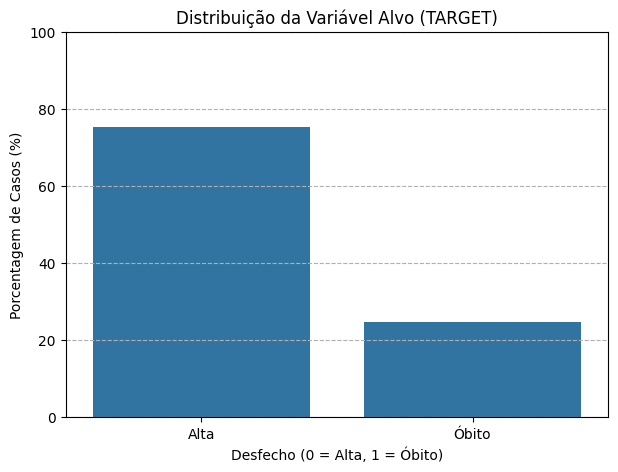

In [72]:
#para pegar a imagem do gráfico
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem percentual do TARGET
contagem_target = df_model['TARGET'].value_counts(normalize=True).mul(100).round(2)

plt.figure(figsize=(7, 5))
sns.barplot(x=contagem_target.index, y=contagem_target.values)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xlabel('Desfecho (0 = Alta, 1 = Óbito)')
plt.ylabel('Porcentagem de Casos (%)')
plt.xticks(ticks=[0, 1], labels=['Alta', 'Óbito'])
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
plt.show()


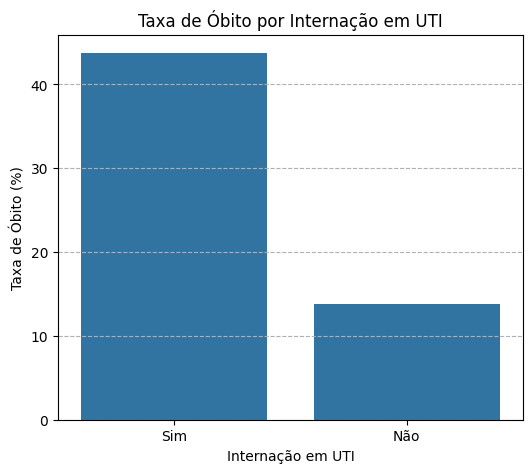

In [73]:
#para pegar a imagem do gráfico
import matplotlib.pyplot as plt
import seaborn as sns

# Filtra valores válidos de UTI (1=Sim, 2=Não)
df_uti = df_model[df_model['UTI'].isin([1, 2])].copy()

# Tabela de proporção (%)
uti_crosstab = pd.crosstab(
    df_uti['UTI'],
    df_uti['TARGET'],
    normalize='index'
).mul(100).round(2)

# Taxa de óbito
uti_crosstab['Taxa_Obito'] = uti_crosstab[1]

plt.figure(figsize=(6, 5))
sns.barplot(x=uti_crosstab.index, y='Taxa_Obito', data=uti_crosstab)
plt.title('Taxa de Óbito por Internação em UTI')
plt.xlabel('Internação em UTI')
plt.ylabel('Taxa de Óbito (%)')
plt.xticks(ticks=[0, 1], labels=['Sim', 'Não'])
plt.grid(axis='y', linestyle='--')
plt.show()
